In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import sys, os, pickle
from autophasemap import plot_clusters
color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd"]

In [3]:
plt.rcParams.update({"text.usetex": True,
                     "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 22,
                     "savefig.dpi": 600,
                     "savefig.bbox": 'tight',
                    }
                   )

In [4]:
with open('./data_smooth8.pkl', 'rb') as f:
    result = pickle.load(f)

In [5]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process=="smoothen":
            self.F = [self._smoothen(self.Iq[i,:]/self.l2norm(self.Iq[i])) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat

saxs = np.load('../../expts/OMIECS/blends_WSCP_P123_NOpH.npz')

q = saxs['q']
n_domain = len(saxs['q'])

C = saxs['C']
Iq = saxs['Iq']

N = C.shape[0]

data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="smoothen")
print('Number of functions : ', data.N)
print('Domain sampling of each function : ', n_domain)

Number of functions :  93
Domain sampling of each function :  1304


In [6]:
def setup_axs():
    fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    axs = axs.flatten()
    
    return fig, axs

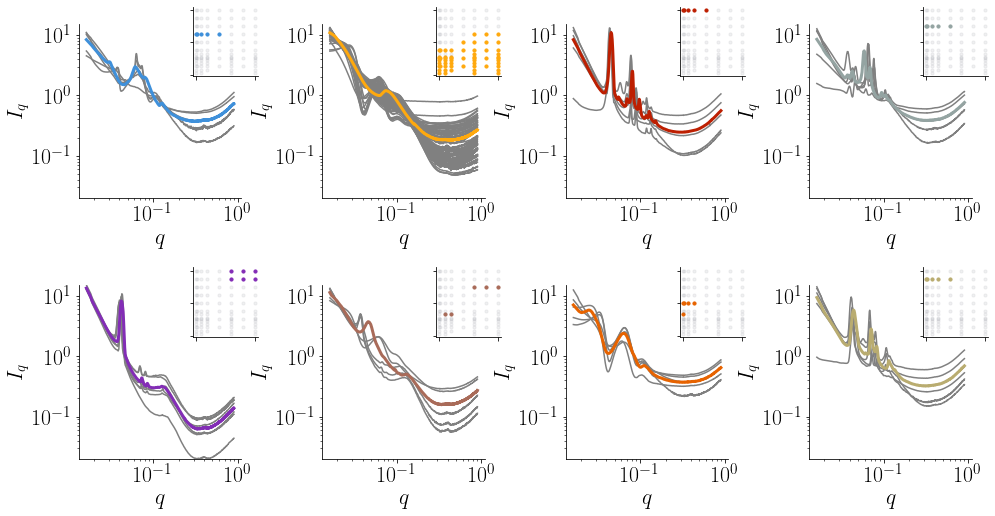

In [7]:
fig, axs = setup_axs()
plot_clusters(axs, data, result, mode="input")

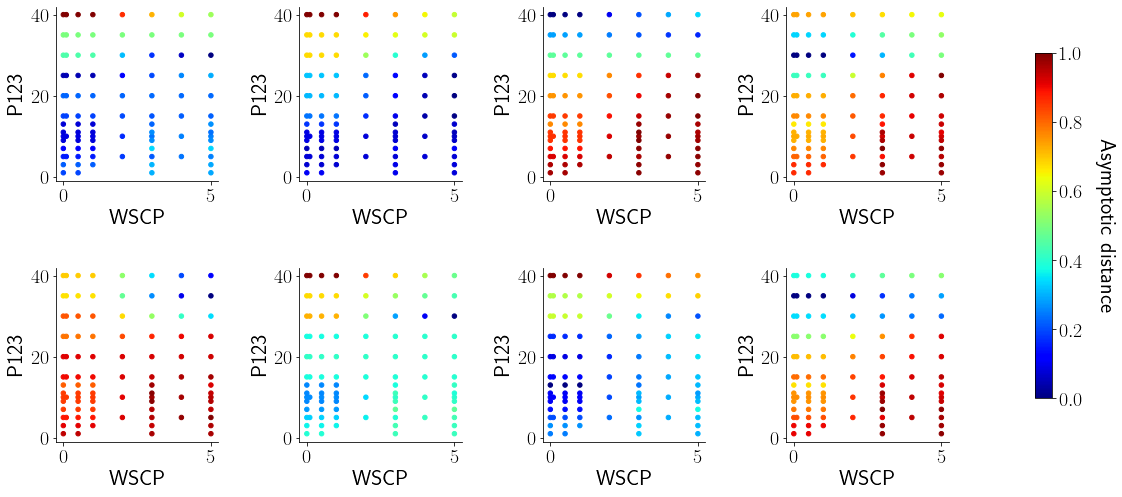

In [8]:
fig, axs = setup_axs()
for k, ax in enumerate(axs):
    cmap = cm.get_cmap('jet')
    ax.scatter(data.C[:,0], 
               data.C[:,1],
               c = result['dist'][:,k],
               cmap=cmap,
               s=20
              )
    ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
    ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
    ax.tick_params(labelsize=20)
    
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cax = plt.axes([0.975, 0.2, 0.015, 0.6])        
cbar = fig.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_ylabel('Asymptotic distance', rotation=270, labelpad=32, fontsize=22)
plt.show()

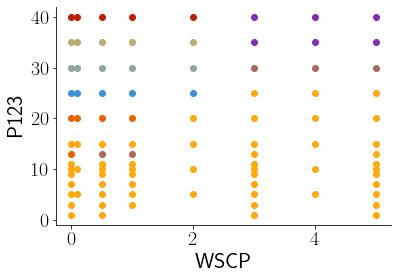

In [9]:
n_clusters = len(np.unique(result["delta_n"]))
fig, ax = plt.subplots()
for k in range(n_clusters):
    Mk = result['delta_n']==k
    ax.scatter(data.C[Mk,0], 
               data.C[Mk,1],
               color = color_blindf[k], 
               alpha=1.0
              )
    
ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
ax.tick_params(labelsize=20)
plt.show()

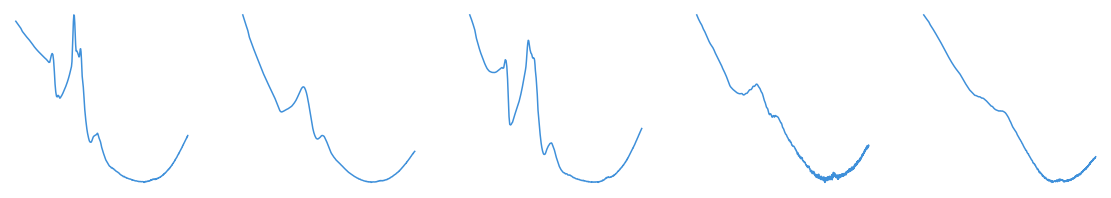

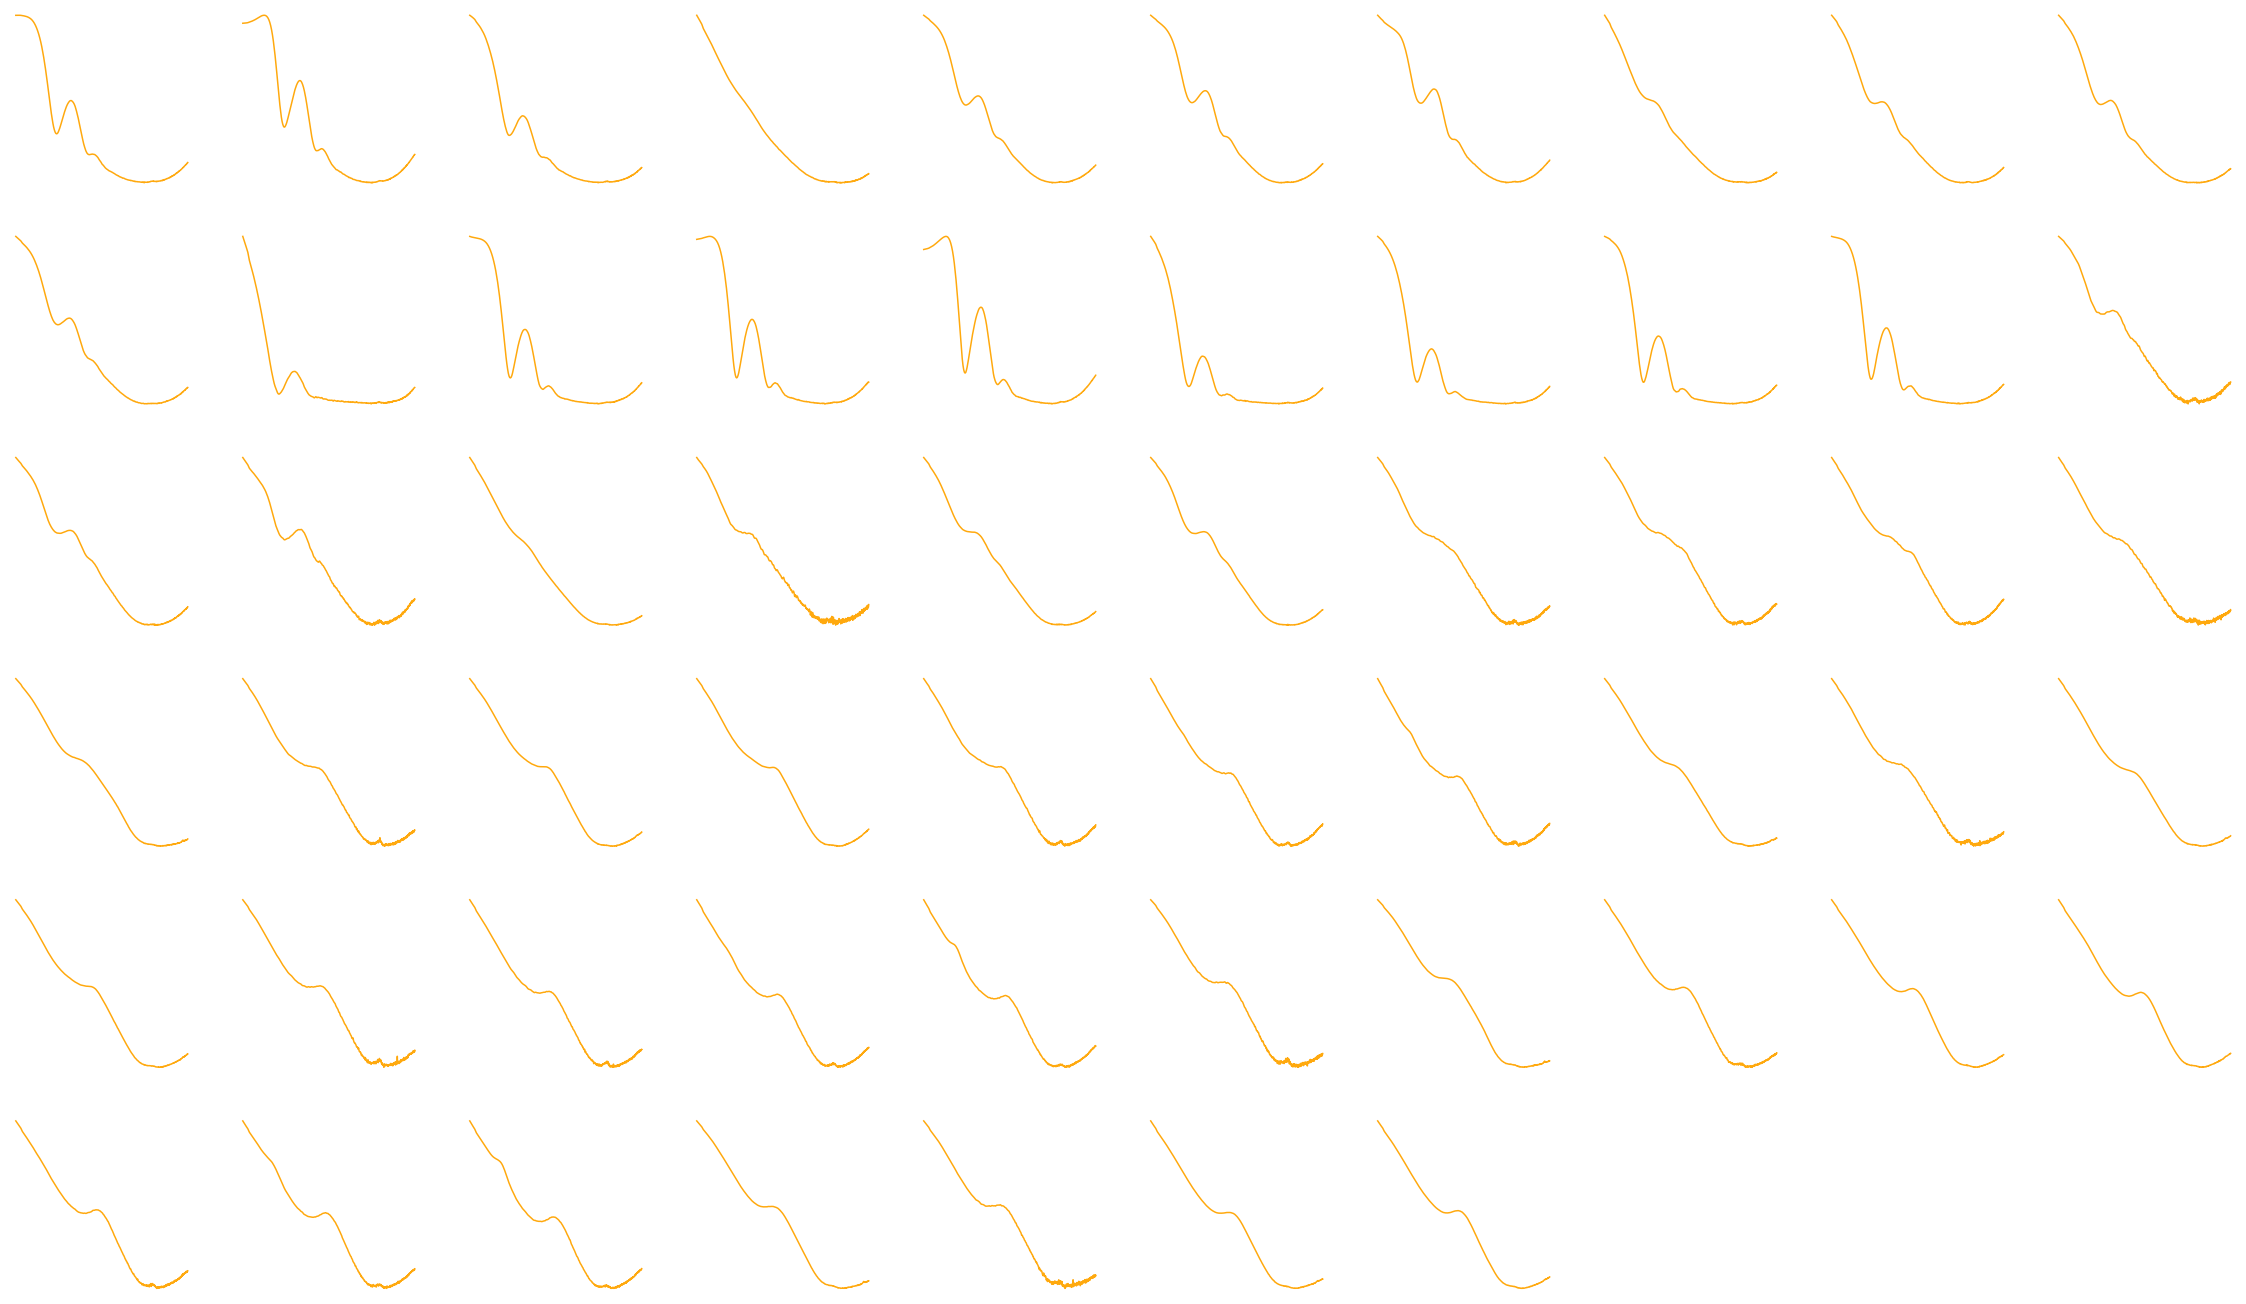

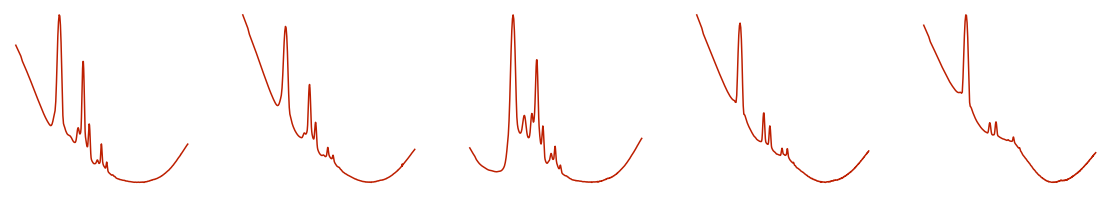

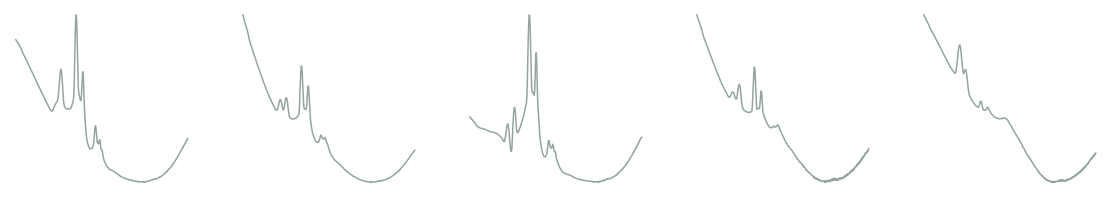

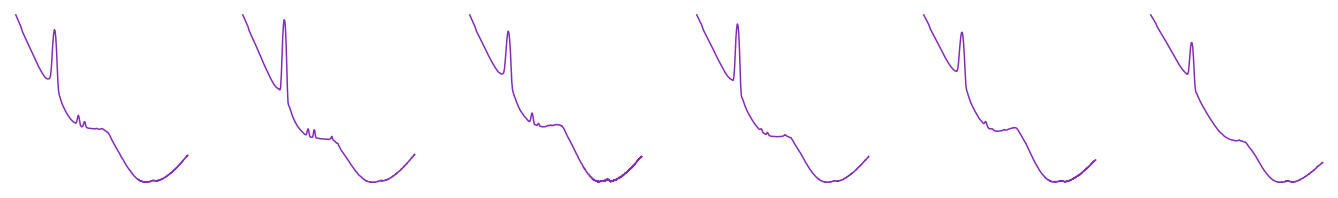

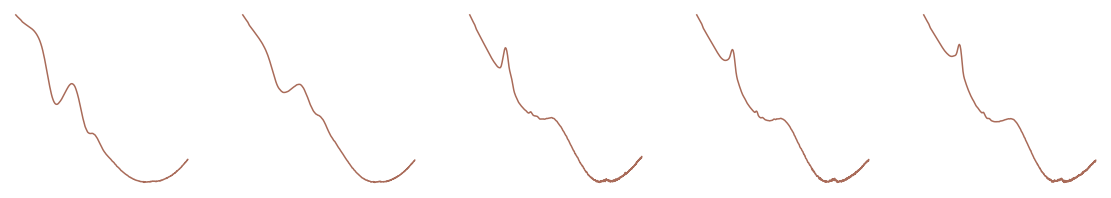

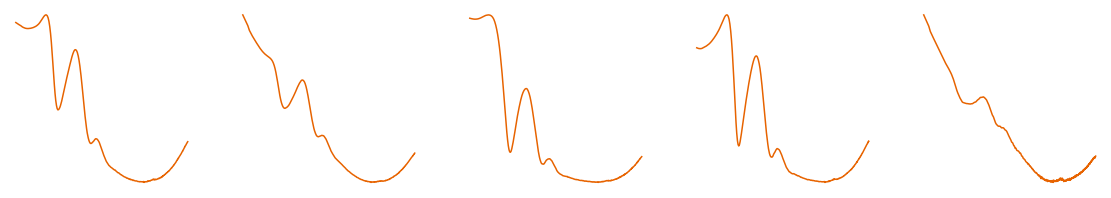

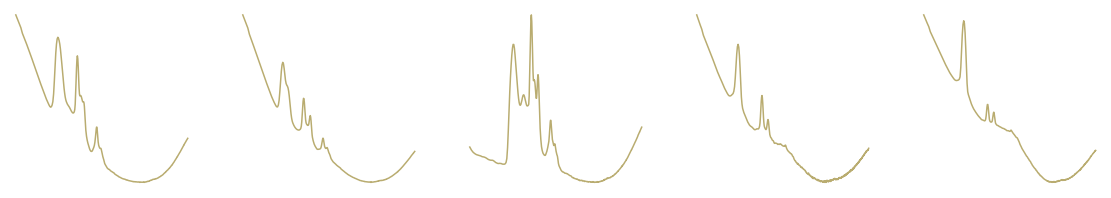

In [10]:
for k in range(n_clusters):
    Mk = np.argwhere(result["delta_n"]==k).squeeze()
    fig, axs = plt.subplots(10,10, figsize=(20*2, 20*2))
    axs = axs.flatten()
    num_plots = np.min([100, len(Mk)])
    [ax.remove() for ax in axs[num_plots:]]
    ax_ind = 0
    for i in Mk:
        ax = axs[ax_ind]
        ax.loglog(data.q, data.F[i], 
                    color=color_blindf[k]
                 )    
        ax.axis('off')
        ax_ind += 1
    plt.show()